On souhaite approximer la probabilité des images MNISt avec une famille de probabilité paramétrique sous la forme : 


$$
\boxed{
p_{\theta} ( x) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
}

$$


L'estimation par maximum de vraisemblance des paramètres de cette famille de probabilité est donnée par :

$$
\boxed{
\hat{\mu} = 1/N \sum_{i=1}^{N} x_i
}

$$


$$
\boxed{
\hat{\Sigma} = 1/N \sum_{i=1}^{N} (x_i - \hat{\mu}) (x_i - \hat{\mu})^T
}

$$




# Importation des librairies

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd


import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import logging
import os

# Importation des données



In [18]:
IMG_SIZE = 32 # Power of 2
NUM_CHANNELS = 1 # Grayscale: 1
NOISE_STEPS = 1000

BATCH_SIZE = 64




In [76]:
fraction = 1 # portion of the dataset (60000 total)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.ToTensor()
])

mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
num_samples = int(len(mnist_data) * fraction)
indices = np.random.choice(len(mnist_data), num_samples, replace=False)
subset_data = torch.utils.data.Subset(mnist_data, indices)
dataloader = torch.utils.data.DataLoader(subset_data, batch_size=BATCH_SIZE, shuffle=True)

# Convert the data to a pandas DataFrame



In [77]:
def Categorize_Images(dataloader):
    List_Df = []
    for digit in range(10):
        List_Df.append([])

    for tensor, label in dataloader:
        List_Df[int(label[0])].append(tensor[0].numpy().flatten())


    for digit in range(10):
        List_Df[digit] = pd.DataFrame(List_Df[digit])

    return List_Df

List_Df = Categorize_Images(dataloader)

# Estimating the parameters of the model

## Estimating the mean

The mean $\mu$ of the model is estimated by the empirical mean of the data.

$$
\hat{\mu} = \frac{1}{N} \sum_{i=1}^{N} x_i
$$



In [78]:
def Estimate_Mean(List_Df):
    List_Mean = []
    for digit in range(10):
        List_Mean.append(List_Df[digit].mean(axis=0))


    return List_Mean

List_Mean = Estimate_Mean(List_Df)

## Estimating the covariance matrix

The covariance matrix $\Sigma$ of the model is estimated by the empirical covariance matrix of the data.

$$
\hat{\Sigma} = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{\mu}) (x_i - \hat{\mu})^T = \frac{1}{N} X^T X
$$



In [79]:
def Estimate_Covariance(List_Df, List_Mean):
    List_Cov = []
    for digit in range(10):
        List_Cov.append(List_Df[digit].cov())

    return List_Cov


List_Cov = Estimate_Covariance(List_Df, List_Mean)

In [80]:
len(List_Cov)

10

# Simulation of the model

In this section, we will simulate the model with the estimated paramters.

In other words, we will simulate a vector $X \sim \mathcal{N}(\hat{\mu}, \hat{\Sigma})$.

$$
X = \hat{\mu} + L \cdot Z
$$

where $Z \sim \mathcal{N}(0, I)$ and $L$ is the Cholesky decomposition of $\hat{\Sigma}$.

In [81]:
def Cholesky_Decomposition(List_Cov,lamda = 1e-6):
    List_L = []
    for digit in range(10):
        List_L.append(np.linalg.cholesky(List_Cov[digit] + lamda * np.eye(1024)))

    return List_L


List_L = Cholesky_Decomposition(List_Cov)

In [82]:
len(List_L)

10

In [89]:
def Simulate_Normal_Distribution(Num_Samples = 1000):
    return np.random.normal(size=(Num_Samples,1024))

def Generate_Samples(List_L, List_Mean, Num_Samples = 1000):
    List_Samples = []
    for digit in range(10):
        Normal_Distribution_Independent = Simulate_Normal_Distribution(Num_Samples)
        Samples_To_Append =  List_L[digit] @ Normal_Distribution_Independent.T + List_Mean[digit].values.reshape(-1,1) 
        List_Samples.append(Samples_To_Append.T)


    return List_Samples


List_Samples = Generate_Samples(List_L, List_Mean, 10)

In [90]:
List_Samples[0].shape

(10, 1024)

# Visualization of the simulated data

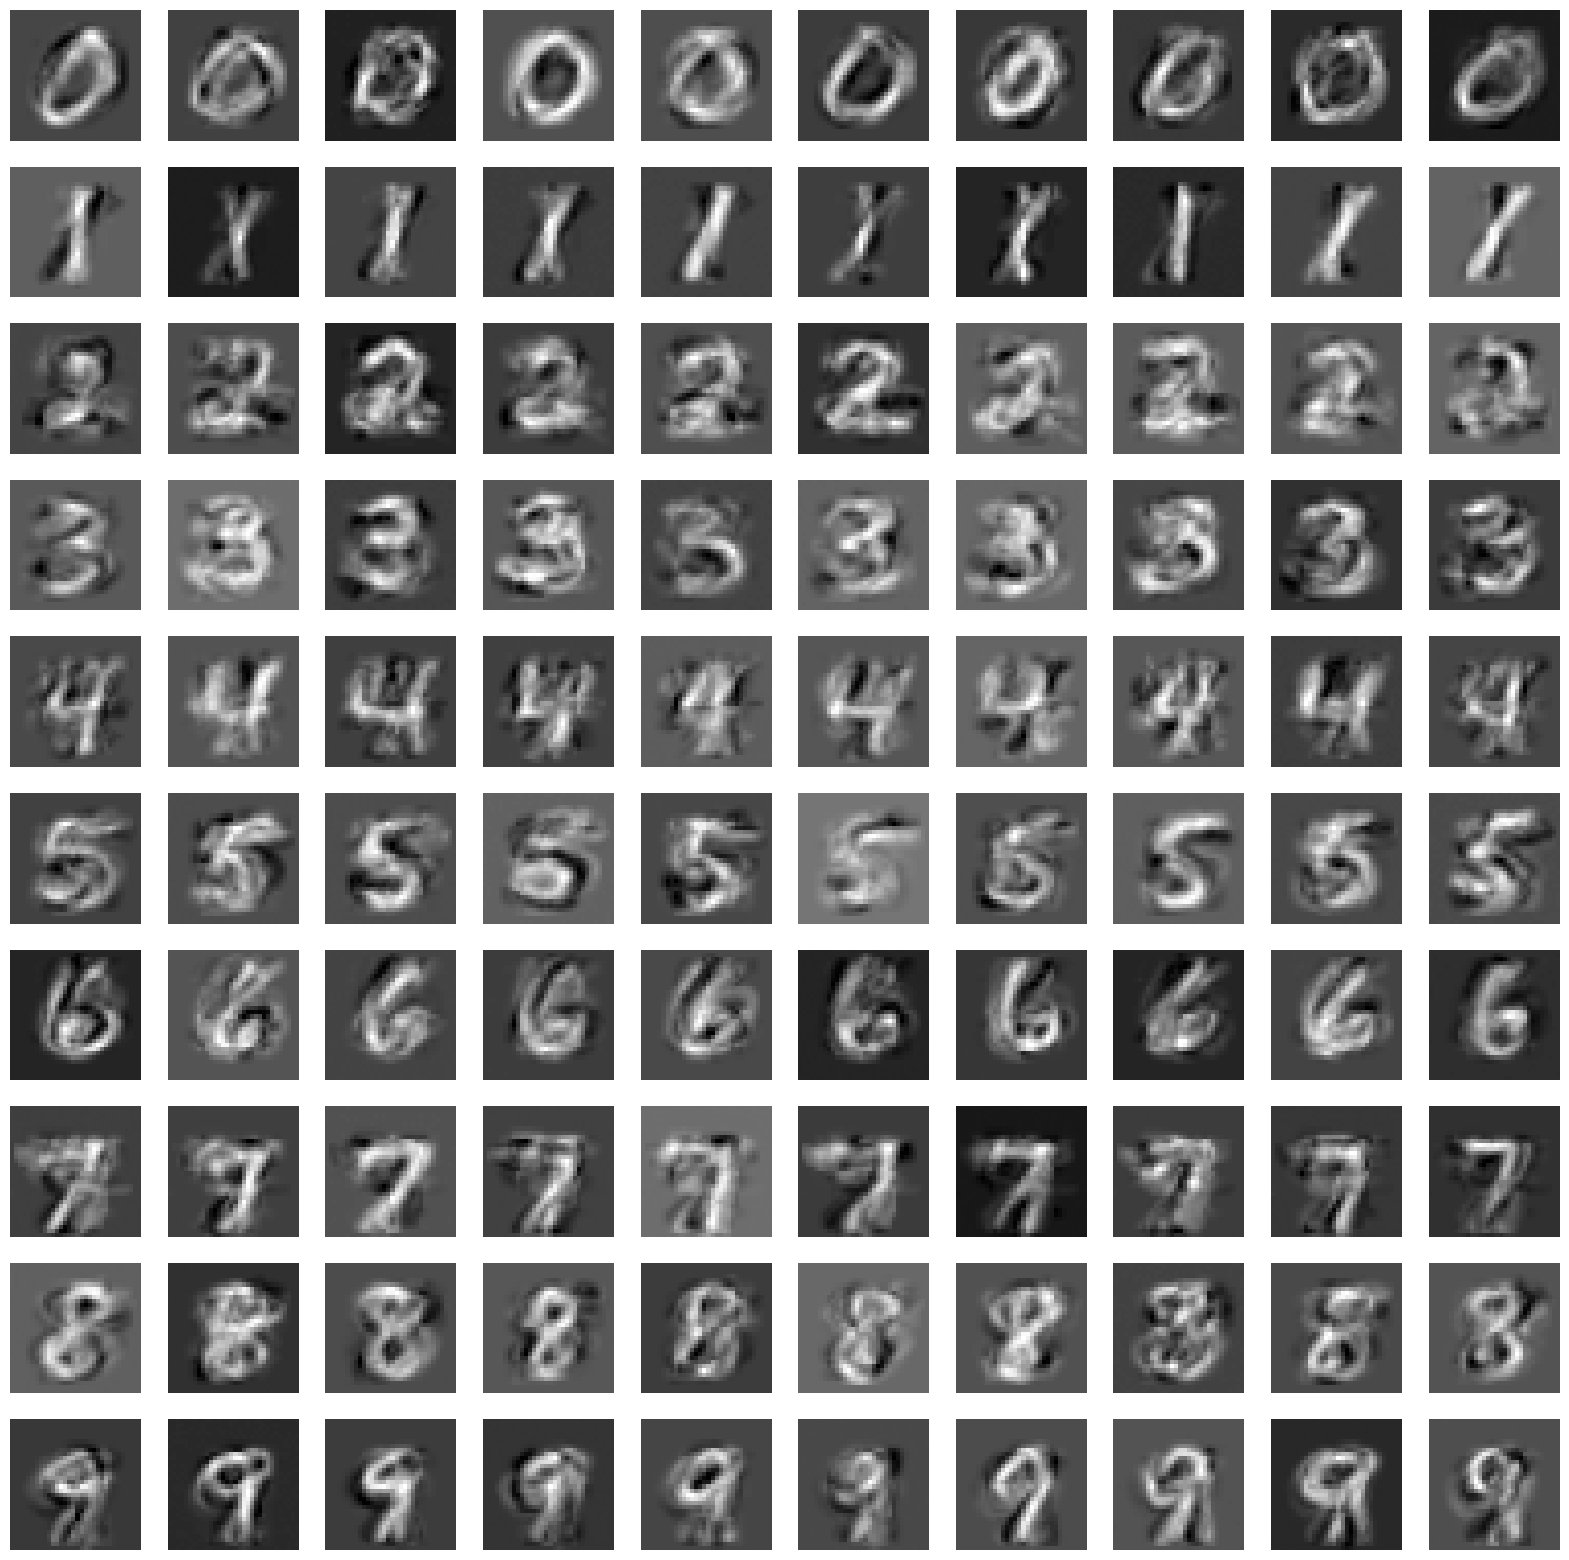

In [91]:
def Plot_Samples(List_Samples):
    fig, axs = plt.subplots(10, List_Samples[0].shape[0], figsize=(20, 20))

    for digit in range(10):
        for sample in range(List_Samples[0].shape[0]):
            axs[digit, sample].imshow(List_Samples[digit][sample].reshape(32,32), cmap='gray')
            axs[digit, sample].axis('off')

    plt.show()


Plot_Samples(List_Samples)
